In [1]:
import time

from discretize import TreeMesh, TensorMesh
from discretize.utils import refine_tree_xyz, active_from_xyz

from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import constants

%matplotlib widget

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

In [2]:
def peak_time(depth, conductivity, mu=constants.mu_0):
    """
    Compute peak time following TDEM diffussion formula
    """
    return 1 / 6 * mu * conductivity * depth**2

def peak_depth(time, conductivity, mu=constants.mu_0):
    """
    Compute peak depth following TDEM diffussion formula
    """
    return np.sqrt(2 * time / mu / conductivity)

Define survey

1 Trasmiter and 1 resivers in the center of the loop

In [3]:
# Defining transmitter locations = (0,0,0)
x, y, z = 0, 0, 0
source_location = np.array([x, y, z])
source_radius = 10  # source loop radius
source_orientation = "z" 
source_current = 1.0  # maximum on-time current


# Define the source waveform. Define a unit step-off.
off_time = 1e-5
waveform = tdem.sources.StepOffWaveform(off_time)

# Observation times for response (time channels)
time_channels = np.logspace(-5, 1, 31)

# Define receiver list. They location is along the x-axis 
receiver_list = []
receiver_orientation = "z"  # "x", "y" or "z"
receiver_list.append(
    tdem.receivers.PointMagneticField(
        np.array([0, 0, 0]), time_channels, orientation=receiver_orientation
    )
)

# Define source list
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

Design mesh and simulation

In [4]:
# Conductivity in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-1


In [5]:
min_simulation_time = off_time
max_simulation_time = 1e-0

Compute minimum and maximum diffusion distances

In [6]:
min_diffusion_distance = min(
    peak_depth(min_simulation_time, background_conductivity),
    peak_depth(min_simulation_time, air_conductivity),
) 

max_diffusion_distance = min(  # if I use the maximum I get crazy large values, I'll go with the min then
    peak_depth(max_simulation_time, background_conductivity),
    peak_depth(max_simulation_time, air_conductivity),
)

min_diffusion_distance, max_diffusion_distance

(12.615662606666971, 3989.4228029284545)

In [7]:
# Estimate smallest cell size as 10% of the smallest diffusion distance

smallest_cell_size = 0.1 * min_diffusion_distance
smallest_cell_size

1.2615662606666973

In [8]:
cell_size = 1    # minimum cell size
n_cells_xz = 2**6
n_cells_y = 2**6

hxz = cell_size * np.ones(n_cells_xz)
hy = cell_size * np.ones(n_cells_y)

mesh = TreeMesh([hxz, hy, hxz],x0="CCC")

# Refine to largest possible cell size
mesh.refine(3, finalize=False)


# Define topography and refine 
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = 0 * np.ones_like(xx)
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Refine mesh
mesh.refine_surface(topo, -1, 
                    padding_cells_by_level=3, 
                    #pad_up=3, 
                    #pad_down=5
                   )
mesh.finalize()

# Set active cells and define unit values
ind_active = active_from_xyz(mesh, topo)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model for cells under the surface topography
model = background_conductivity * np.ones(ind_active.sum())



In [9]:
receiver_list[0].locations[0]

array([0., 0., 0.])

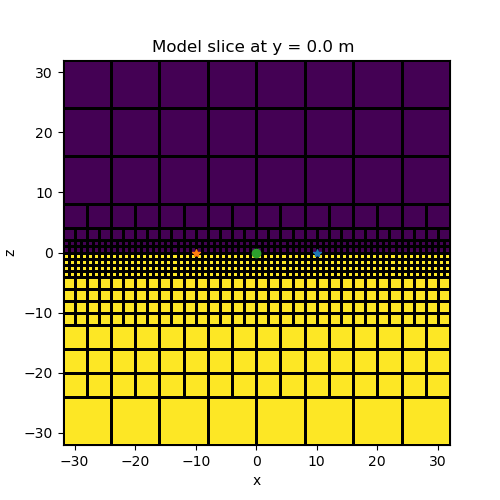

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal='y', ax=ax, grid=True, ind=ind_slice)
ax.set_title(f"Model slice at y = {mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice])} m ")
plt.plot(source_radius, 0, '*')
plt.plot(-source_radius, 0, '*')
plt.plot(receiver_list[0].locations[0][0], 0* np.ones_like(receiver_list[0]), 'o')
plt.show()

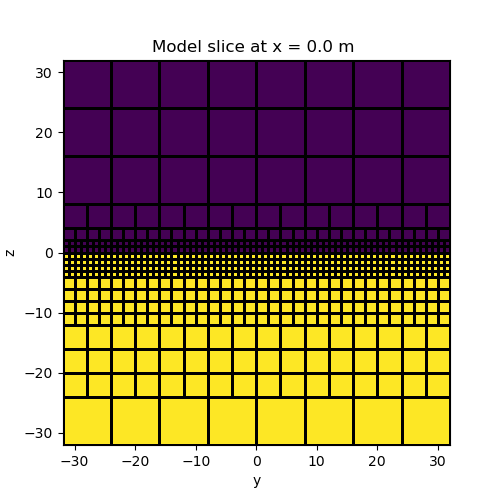

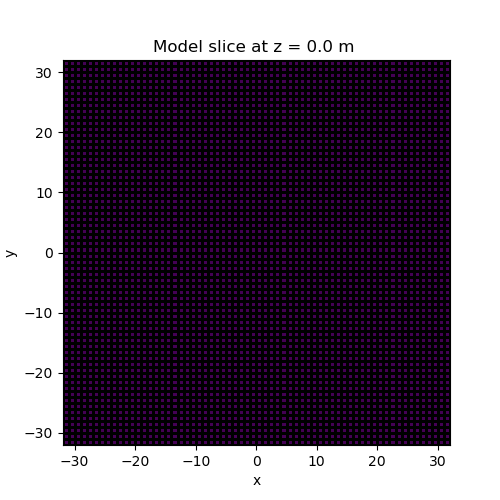

In [11]:
# Plot

for ni, axi in enumerate(['x', 'z']):
    fig, ax = plt.subplots(figsize=(5, 5))
    ind_slice = int(mesh.h[ni].size / 2)
    mesh.plot_slice(model_map * model, normal=axi, ax=ax, grid=True, 
                    ind=ind_slice
                   )
    ax.set_title(f"Model slice at {axi} = {mesh.x0[ni] + np.sum(mesh.h[ni][0:ind_slice])} m ")
    plt.show()



In [12]:
mesh

OcTreeMesh: 11.82% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       256            ---------------------------   --------------------
  4   :      1024         x:     -32.0    ,    32.0           1.0    ,    8.0    
  5   :      5120         y:     -32.0    ,    32.0           1.0    ,    8.0    
  6   :      24576        z:     -32.0    ,    32.0           1.0    ,    8.0    
-----------------------
Total :      30976

Simulation:

In [13]:
time_steps = [
            (1e-5, 10),
            (5e-5, 10),
            (1e-4, 10),
            (1e-3, 10),
            (5e-3, 10),
            (5e-2, 10),
            (1e-2, 10),
            (1e-1, 10),
            (1e-0, 9),
             ]

simulation = tdem.simulation.Simulation3DMagneticField(
    mesh, survey=survey, sigmaMap=model_map, solver=Solver
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps


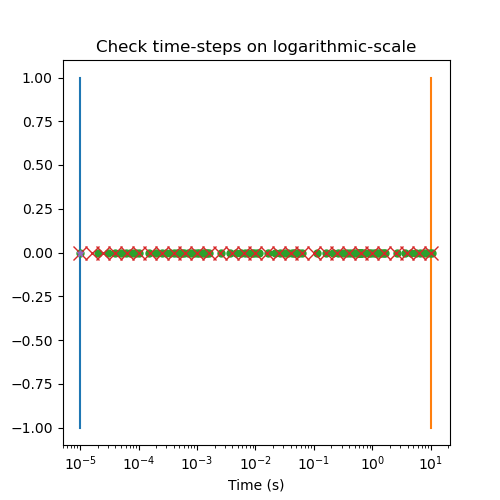

Min/max times    : 1.0e-05 / 1.0e+01
Min/max timeSteps: 1.0e-05 / 1.1e+01


In [14]:
# Logarithmic scale
# Create mesh with time steps
ts = TensorMesh([time_steps]).nodes_x


fig, ax = plt.subplots(figsize=(5, 5))
plt.title("Check time-steps on logarithmic-scale")
plt.plot([time_channels.min(), time_channels.min()], [-1, 1])
plt.plot([time_channels.max(), time_channels.max()], [-1, 1])

plt.plot(ts, ts * 0, ".", ms=10)
plt.plot(time_channels, time_channels*0, "x", ms=10)
plt.plot(off_time, off_time * 0, "*", ms=5)
plt.xscale("log")
plt.xlabel("Time (s)")
plt.show()

# Check times with time-steps
print(f"Min/max times    : {time_channels.min():.1e} / {time_channels.max():.1e}")
print(f"Min/max timeSteps: {ts[1]:.1e} / {ts[-1]:.1e}")

In [15]:
# Data are organized by transmitter, then by receiver then by observation time.
start = time.time()
dpred = simulation.dpred(model)
end = time.time()

print(f"Elapsed time: {end - start:.2f}s")


/home/agustina.pesce/.mambaforge/envs/simpeg-env/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/agustina.pesce/.mambaforge/envs/simpeg-env/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


Elapsed time: 16.06s


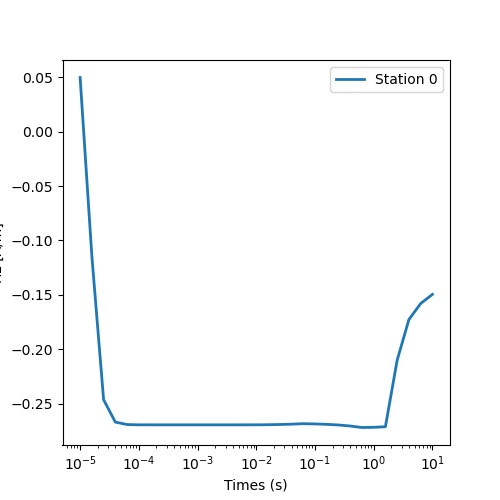

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(time_channels, dpred, lw=2, label=f'Station {0}')

ax.set_xscale('log')
ax.set_xlabel("Times (s)")
ax.set_ylabel('Hz [A/m]')
#plt.plot([ts.min(), ts.min()], [-1, 1])
#plt.plot([ts.max(), ts.max()], [-1, 1])
plt.legend()
plt.show()

In [17]:
off_time

1e-05

In [18]:
# Theorical value for Bz [T]
constants.mu_0 * source_current / (2 * source_radius)

6.283185310599999e-08

In [19]:
# Teorical value for Hz [A/m]
source_current / ( 2 * source_radius)

0.05

In [20]:
# Value of time channel 0
dpred.max()

0.049859182768399665

In [28]:
dpred

array([ 0.04985918, -0.11431932, -0.24648415, -0.26704323, -0.26929953,
       -0.2695681 , -0.26957822, -0.26957923, -0.26957871, -0.26957819,
       -0.26958078, -0.26958489, -0.2695832 , -0.2695803 , -0.2695757 ,
       -0.26956841, -0.26947465, -0.26927716, -0.26896466, -0.26851182,
       -0.26874632, -0.26911871, -0.26971126, -0.27065607, -0.2720291 ,
       -0.27186211, -0.27132098, -0.2101345 , -0.17276609, -0.15803702,
       -0.14961925])

The value of the time channel 0 and the theorical value of Hz mast be equal. 

In [22]:
# Compute the raduis of the loop according to the time channel 0 
1 / (dpred.max() * 2 / source_current)

10.028242988308582

This value is similar to the used in the simulation.

In [23]:
from geoana.em.tdem import vertical_magnetic_field_horizontal_loop

In [24]:
np.logspace(-10, 1, 31)

array([1.00000000e-10, 2.32630507e-10, 5.41169527e-10, 1.25892541e-09,
       2.92864456e-09, 6.81292069e-09, 1.58489319e-08, 3.68694506e-08,
       8.57695899e-08, 1.99526231e-07, 4.64158883e-07, 1.07977516e-06,
       2.51188643e-06, 5.84341413e-06, 1.35935639e-05, 3.16227766e-05,
       7.35642254e-05, 1.71132830e-04, 3.98107171e-04, 9.26118728e-04,
       2.15443469e-03, 5.01187234e-03, 1.16591440e-02, 2.71227258e-02,
       6.30957344e-02, 1.46779927e-01, 3.41454887e-01, 7.94328235e-01,
       1.84784980e+00, 4.29866235e+00, 1.00000000e+01])

In [25]:
time_channels

array([1.00000000e-05, 1.58489319e-05, 2.51188643e-05, 3.98107171e-05,
       6.30957344e-05, 1.00000000e-04, 1.58489319e-04, 2.51188643e-04,
       3.98107171e-04, 6.30957344e-04, 1.00000000e-03, 1.58489319e-03,
       2.51188643e-03, 3.98107171e-03, 6.30957344e-03, 1.00000000e-02,
       1.58489319e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02,
       1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 3.98107171e-01,
       6.30957344e-01, 1.00000000e+00, 1.58489319e+00, 2.51188643e+00,
       3.98107171e+00, 6.30957344e+00, 1.00000000e+01])

In [35]:
hz = vertical_magnetic_field_horizontal_loop(time_channels-1e-5, sigma=background_conductivity, radius=source_radius, current=source_current,)
hz

/home/agustina.pesce/.mambaforge/envs/simpeg-env/lib/python3.8/site-packages/geoana/em/tdem/simple_functions.py:66: RuntimeWarning: divide by zero encountered in divide
  theta = np.sqrt((sigma * mu_0) / (4 * t))


array([5.00000000e-02, 4.74138399e-03, 1.30518623e-03, 4.92125786e-04,
       2.11133762e-04, 9.66656558e-05, 4.58820899e-05, 2.22413400e-05,
       1.09190600e-05, 5.40237332e-06, 2.68581004e-06, 1.33927792e-06,
       6.69088429e-07, 3.34664596e-07, 1.67517072e-07, 8.38903183e-08,
       4.20235622e-08, 2.10549757e-08, 1.05503673e-08, 5.28704049e-09,
       2.64958828e-09, 1.32787363e-09, 6.65494326e-10, 3.33534445e-10,
       1.67165126e-10, 8.37928837e-11, 4.19959179e-11, 2.10548023e-11,
       1.05501385e-11, 5.27506927e-12, 2.70574674e-12])

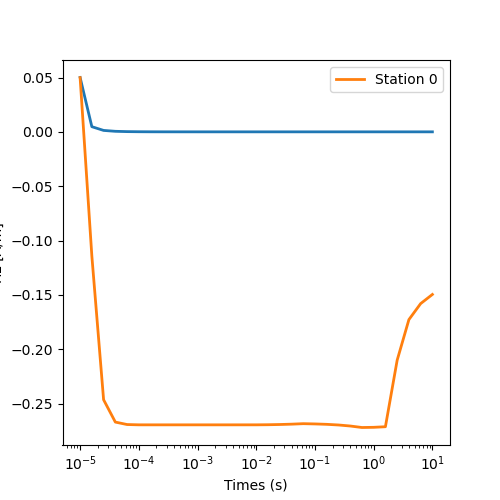

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(time_channels, hz, lw=2,)
ax.plot(time_channels, dpred, lw=2, label=f'Station {0}')

ax.set_xscale('log')
ax.set_xlabel("Times (s)")
ax.set_ylabel('Hz [A/m]')
#plt.plot([ts.min(), ts.min()], [-1, 1])
#plt.plot([ts.max(), ts.max()], [-1, 1])
plt.legend()
plt.show()